In [18]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix, coo_matrix, issparse
from scipy.sparse.linalg import eigsh, eigs
from scipy.special import factorial, comb
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from itertools import combinations
#from quspin.basis import spin_basis_1d, spin_basis_general
#import tenpy as tp

In [19]:
# spinful jw - single site operators

# Four basis states for each site: |0>, |↑>, |↓>, |↑↓>
ket_empty = csr_matrix([[1], [0], [0], [0]], dtype=np.complex128)  # |0>
ket_up = csr_matrix([[0], [1], [0], [0]], dtype=np.complex128)     # |↑>
ket_down = csr_matrix([[0], [0], [1], [0]], dtype=np.complex128)   # |↓>
ket_both = csr_matrix([[0], [0], [0], [1]], dtype=np.complex128)   # |↑↓>

# Single-site operators for spin-up
# Annihilation operator c_↑
c_up = csr_matrix([
    [0, 1, 0, 0],  # |0> -> 0
    [0, 0, 0, 0],  # |↑> -> |0>
    [0, 0, 0, 1],  # |↓> -> 0
    [0, 0, 0, 0]   # |↑↓> -> |↓>
], dtype=np.complex128)

# Creation operator c†_↑
c_up_dag = c_up.getH()

# Single-site operators for spin-down
# Annihilation operator c_↓
c_down = csr_matrix([
    [0, 0, 1, 0],   # |0> -> 0
    [0, 0, 0, -1],   # |↑> -> 0
    [0, 0, 0, 0],   # |↓> -> |0>
    [0, 0, 0, 0]   # |↑↓> -> -|↑> (anticommutation with c†_↑)
], dtype=np.complex128)

# Creation operator c†_↓
c_down_dag = c_down.getH()

# Number operators
n_up = c_up_dag @ c_up
n_down = c_down_dag @ c_down
n_total_site = n_up + n_down

# Identity operator (4x4 for spinful sites)
I_4 = identity(4, format='csr', dtype=np.complex128)

# Parity operator P = (-1)^n for Jordan-Wigner string
P = csr_matrix([
    [1, 0, 0, 0],   # |0> -> +|0>
    [0, -1, 0, 0],  # |↑> -> -|↑>
    [0, 0, -1, 0],  # |↓> -> -|↓>
    [0, 0, 0, 1]    # |↑↓> -> +|↑↓>
], dtype=np.complex128)

# --- Verification function ---
def verify_spinful_operators():
    """Verify the action of operators on the 4 basis states"""
    print("=== Verification of Spinful Operators ===")
    
    states = [ket_empty, ket_up, ket_down, ket_both]
    state_names = ["|0>", "|↑>", "|↓>", "|↑↓>"]
    
    print("\n1. Spin-up creation operator c†_↑:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = c_up_dag @ state
        print(f"   c†_↑ {name} = {result.toarray().flatten()}")
    
    print("\n2. Spin-up annihilation operator c_↑:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = c_up @ state
        print(f"   c_↑ {name} = {result.toarray().flatten()}")
    
    print("\n3. Spin-down creation operator c†_↓:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = c_down_dag @ state
        print(f"   c†_↓ {name} = {result.toarray().flatten()}")
    
    print("\n4. Spin-down annihilation operator c_↓:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = c_down @ state
        print(f"   c_↓ {name} = {result.toarray().flatten()}")
    
    print("\n5. Number operators:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        n_up_result = (n_up @ state).toarray().flatten()
        n_down_result = (n_down @ state).toarray().flatten()
        n_total_result = (n_total_site @ state).toarray().flatten()
        print(f"   n_↑ {name} = {n_up_result}")
        print(f"   n_↓ {name} = {n_down_result}")
        print(f"   n_total {name} = {n_total_result}")
    
    print("\n6. Parity operator P:")
    for i, (state, name) in enumerate(zip(states, state_names)):
        result = (P @ state).toarray().flatten()
        print(f"   P {name} = {result}")
    
    print("\n7. Verify anticommutation on same site:")
    # {c_↑, c†_↓} = 0 and {c_↓, c†_↑} = 0
    anticomm1 = c_up @ c_down_dag + c_down_dag @ c_up
    anticomm2 = c_down @ c_up_dag + c_up_dag @ c_down
    print(f"   {{c_↑, c†_↓}} = \n{anticomm1.toarray()}")
    print(f"   {{c_↓, c†_↑}} = \n{anticomm2.toarray()}")
    
    # {c_↑, c†_↑} = 1 and {c_↓, c†_↓} = 1
    anticomm3 = c_up @ c_up_dag + c_up_dag @ c_up
    anticomm4 = c_down @ c_down_dag + c_down_dag @ c_down
    print(f"   {{c_↑, c†_↑}} = \n{anticomm3.toarray()}")
    print(f"   {{c_↓, c†_↓}} = \n{anticomm4.toarray()}")


# Run verification
verify_spinful_operators()

=== Verification of Spinful Operators ===

1. Spin-up creation operator c†_↑:
   c†_↑ |0> = [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
   c†_↑ |↑> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c†_↑ |↓> = [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
   c†_↑ |↑↓> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]

2. Spin-up annihilation operator c_↑:
   c_↑ |0> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↑ |↑> = [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↑ |↓> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↑ |↑↓> = [0.+0.j 0.+0.j 1.+0.j 0.+0.j]

3. Spin-down creation operator c†_↓:
   c†_↓ |0> = [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
   c†_↓ |↑> = [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
   c†_↓ |↓> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c†_↓ |↑↓> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]

4. Spin-down annihilation operator c_↓:
   c_↓ |0> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↓ |↑> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↓ |↓> = [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
   c_↓ |↑↓> = [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]

5. Number operators:
   n_↑ |0> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
   n_↓ |0> = [0.+0.j 0.+0.j 0.+

In [20]:
def full_operator_spinful(L, op, site):
    """
    Create full fermionic operator with Jordan-Wigner string
    Args:
        L: number of sites
        op: single-site operator (c_up, c_up_dag, c_down, c_down_dag, etc.)
        site: site index (0 to L-1)
    """
    if site >= L or site < 0:
        raise ValueError(f"Site index {site} out of range for {L} sites")
    
    result = 1
    for i in range(L):
        if i < site:
            # Jordan-Wigner string: parity operator for all sites to the left
            result = kron(result, P, format='csr')
        elif i == site:
            # Apply the operator at the target site
            result = kron(result, op, format='csr')
        else:
            # Identity for sites to the right
            result = kron(result, I_4, format='csr')
    return result

def creation_operator_up(L, site):
    """Creation operator c†_↑,i with Jordan-Wigner string"""
    return full_operator_spinful(L, c_up_dag, site)

def annihilation_operator_up(L, site):
    """Annihilation operator c_↑,i with Jordan-Wigner string"""
    return full_operator_spinful(L, c_up, site)

def creation_operator_down(L, site):
    """Creation operator c†_↓,i with Jordan-Wigner string"""
    return full_operator_spinful(L, c_down_dag, site)

def annihilation_operator_down(L, site):
    """Annihilation operator c_↓,i with Jordan-Wigner string"""
    return full_operator_spinful(L, c_down, site)

def number_operator_up(L, site):
    """Number operator n_↑,i = c†_↑,i c_↑,i"""
    return full_operator_spinful(L, n_up, site)

def number_operator_down(L, site):
    """Number operator n_↓,i = c†_↓,i c_↓,i"""
    return full_operator_spinful(L, n_down, site)

def number_operator_total_site(L, site):
    """Total number operator n_i = n_↑,i + n_↓,i"""
    return full_operator_spinful(L, n_total_site, site)

def total_number_operator_spinful(L):
    """Total number operator N = Σ_i (n_↑,i + n_↓,i)"""
    N_total = csr_matrix((4**L, 4**L), dtype=np.complex128)
    for i in range(L):
        N_total += number_operator_up(L, i)
        N_total += number_operator_down(L, i)
    return N_total

# --- Check anticommutation relations ---
def check_anticommutation_spinful(L, site_i, site_j):
    """Check anticommutators for spinful fermion operators"""
    # Get all operators
    ci_up = annihilation_operator_up(L, site_i)
    ci_up_dag = creation_operator_up(L, site_i)
    ci_down = annihilation_operator_down(L, site_i)
    ci_down_dag = creation_operator_down(L, site_i)
    
    cj_up = annihilation_operator_up(L, site_j)
    cj_up_dag = creation_operator_up(L, site_j)
    cj_down = annihilation_operator_down(L, site_j)
    cj_down_dag = creation_operator_down(L, site_j)
    
    results = {}
    
    # Same site, same spin: {c_σ,i, c†_σ,i} = 1
    anticomm_same_up = ci_up @ ci_up_dag + ci_up_dag @ ci_up
    anticomm_same_down = ci_down @ ci_down_dag + ci_down_dag @ ci_down
    results[f"{{c_↑,{site_i}, c†_↑,{site_i}}}"] = anticomm_same_up.todense()
    results[f"{{c_↓,{site_i}, c†_↓,{site_i}}}"] = anticomm_same_down.todense()
    
    if site_i != site_j:
        # Different sites, same spin: {c_σ,i, c†_σ,j} = 0
        anticomm_diff_up = ci_up @ cj_up_dag + cj_up_dag @ ci_up
        anticomm_diff_down = ci_down @ cj_down_dag + cj_down_dag @ ci_down
        results[f"{{c_↑,{site_i}, c†_↑,{site_j}}}"] = anticomm_diff_up.todense()
        results[f"{{c_↓,{site_i}, c†_↓,{site_j}}}"] = anticomm_diff_down.todense()
        
        # Different sites, different spins: {c_σ,i, c†_σ',j} = 0
        anticomm_diff_mixed1 = ci_up @ cj_down_dag + cj_down_dag @ ci_up
        anticomm_diff_mixed2 = ci_down @ cj_up_dag + cj_up_dag @ ci_down
        results[f"{{c_↑,{site_i}, c†_↓,{site_j}}}"] = anticomm_diff_mixed1.todense()
        results[f"{{c_↓,{site_i}, c†_↑,{site_j}}}"] = anticomm_diff_mixed2.todense()
    
    # Same site, different spins: {c_σ,i, c†_σ',i} = 0
    anticomm_same_mixed1 = ci_up @ ci_down_dag + ci_down_dag @ ci_up
    anticomm_same_mixed2 = ci_down @ ci_up_dag + ci_up_dag @ ci_down
    results[f"{{c_↑,{site_i}, c†_↓,{site_i}}}"] = anticomm_same_mixed1.todense()
    results[f"{{c_↓,{site_i}, c†_↑,{site_i}}}"] = anticomm_same_mixed2.todense()
    
    return results

# check anticommutation relations for L sites
L = 4
anticom_results = check_anticommutation_spinful(L, 0, 1)
for key, value in anticom_results.items():
    print(f"{key}: {np.round(value, 5)}")

{c_↑,0, c†_↑,0}: [[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]
{c_↓,0, c†_↓,0}: [[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]
{c_↑,0, c†_↑,1}: [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
{c_↓,0, c†_↓,1}: [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.

In [21]:
# Fixed Normal ordering for spinful fermion operators with proper swap counting

def get_operator_priority(op_type, site, spin):
    """
    Get priority for operator ordering:
    1. Creation operators first (lower priority number)
    2. Within creation/annihilation: increasing site number
    3. Within same site: up spin before down spin
    """
    if op_type == 'c_dag':
        base_priority = 0  # Creation operators come first
    else:  # op_type == 'c'
        base_priority = 1000  # Annihilation operators come after
    
    site_priority = site * 10  # Site ordering
    
    if spin == 'up':
        spin_priority = 0
    else:  # spin == 'down'
        spin_priority = 1
    
    return base_priority + site_priority + spin_priority

def count_swaps_to_sort(operators_list):
    """
    Count the number of adjacent swaps needed to sort operators by priority.
    This is equivalent to counting inversions, which gives the correct sign.
    """
    if len(operators_list) <= 1:
        return 0, operators_list
    
    # Create list with priorities and original positions
    indexed_ops = [(get_operator_priority(op[0], op[1], op[2]), i, op) 
                   for i, op in enumerate(operators_list)]
    
    # Use bubble sort to count swaps (this counts exactly the inversions)
    ops_copy = indexed_ops.copy()
    swap_count = 0
    n = len(ops_copy)
    
    for i in range(n):
        for j in range(0, n - i - 1):
            if ops_copy[j][0] > ops_copy[j + 1][0]:
                # Swap needed - this represents an anticommutation
                ops_copy[j], ops_copy[j + 1] = ops_copy[j + 1], ops_copy[j]
                swap_count += 1
    
    # Extract the sorted operator list
    sorted_ops = [op[2] for op in ops_copy]
    
    return swap_count, sorted_ops

def normal_order_operator_list(operators_list):
    """
    Normal order a list of (op_type, site, spin) tuples.
    Returns: (sign, ordered_list) where sign accounts for fermion anticommutations
    """
    if len(operators_list) <= 1:
        return 1.0, operators_list
    
    # Count swaps needed and get sorted list
    swap_count, sorted_ops = count_swaps_to_sort(operators_list)
    
    # Each swap introduces a minus sign due to anticommutation
    sign = (-1) ** swap_count
    
    return sign, sorted_ops

def normal_order_product_spinful(operators_list, L):
    """
    Normal order a product of spinful fermion operators and return the resulting operator.
    
    Args:
        operators_list: List of (op_type, site, spin) tuples
                       op_type: 'c_dag' or 'c'
                       site: integer site index
                       spin: 'up' or 'down'
        L: system size
        
    Returns:
        List of (coefficient, sparse_matrix) tuples representing normal ordered terms
    """
    if len(operators_list) == 0:
        identity_op = identity(4**L, format='csr', dtype=np.complex128)
        return [(1.0, identity_op)]
    
    # Check for repeated operators that give zero (Pauli exclusion)
    op_counts = {}
    for op in operators_list:
        key = (op[0], op[1], op[2])  # (type, site, spin)
        op_counts[key] = op_counts.get(key, 0) + 1 # for a given key, the corresponding value is the count
    
    # If any operator appears more than once, result is zero
    for count in op_counts.values():
        if count > 1:
            zero_op = csr_matrix((4**L, 4**L), dtype=np.complex128)
            return [(0.0, zero_op)]
    
    # Get the normal ordered form with correct sign
    sign, ordered_ops = normal_order_operator_list(operators_list)
    
    # Construct the full operator by multiplying individual operators
    result_op = identity(4**L, format='csr', dtype=np.complex128)
    
    for op_type, site, spin in ordered_ops:
        if op_type == 'c_dag' and spin == 'up':
            op = creation_operator_up(L, site)
        elif op_type == 'c_dag' and spin == 'down':
            op = creation_operator_down(L, site)
        elif op_type == 'c' and spin == 'up':
            op = annihilation_operator_up(L, site)
        elif op_type == 'c' and spin == 'down':
            op = annihilation_operator_down(L, site)
        else:
            raise ValueError(f"Invalid operator: {op_type}, {spin}")
        
        result_op = result_op @ op
    
    return [(complex(sign), result_op)]

def print_operator_sequence(operators_list):
    """Print the operator sequence in readable form"""
    op_strings = []
    for op_type, site, spin in operators_list:
        if op_type == 'c_dag':
            symbol = f"c†_{spin[0]},{site}"
        else:
            symbol = f"c_{spin[0]},{site}"
        op_strings.append(symbol)
    return " ".join(op_strings)

def test_normal_ordering_comprehensive():
    """Comprehensive test of the normal ordering function"""
    L = 4
    print("=== Comprehensive Normal Ordering Tests ===\n")
    
    # Test 1: Already in normal order
    print("Test 1: c†_u,0 c†_d,0 (already normal ordered)")
    ops = [('c_dag', 0, 'up'), ('c_dag', 0, 'down')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    print(f"Swaps needed: 0 (already ordered)\n")
    
    # Test 2: Simple swap - spin ordering
    print("Test 2: c†_d,0 c†_u,0 -> need to swap spins")
    ops = [('c_dag', 0, 'down'), ('c_dag', 0, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    print(f"Swaps needed: 1 -> sign = (-1)^1 = -1\n")
    
    # Test 3: Site ordering
    print("Test 3: c†_u,1 c†_u,0 -> need to swap sites")
    ops = [('c_dag', 1, 'up'), ('c_dag', 0, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    print(f"Swaps needed: 1 -> sign = (-1)^1 = -1\n")
    
    # Test 4: Creation vs annihilation
    print("Test 4: c_u,0 c†_u,1 -> creation should come first")
    ops = [('c', 0, 'up'), ('c_dag', 1, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    print(f"Swaps needed: 1 -> sign = (-1)^1 = -1\n")
    
    # Test 5: Multiple swaps
    print("Test 5: c_d,1 c†_d,0 c_u,0 c†_u,1 -> multiple reorderings")
    ops = [('c', 1, 'down'), ('c_dag', 0, 'down'), ('c', 0, 'up'), ('c_dag', 1, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    
    # Let's manually trace the swaps:
    # Start: c_d,1 c†_d,0 c_u,0 c†_u,1
    # Target order: c†_u,0 c†_d,0 c†_u,1 c_u,0 c_d,1
    # But we need c†_u,1 not c†_u,0 twice, so:
    # Target: c†_u,1 c†_d,0 c_u,0 c_d,1
    
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    
    # Count swaps manually to verify
    swap_count, _ = count_swaps_to_sort(ops)
    print(f"Swaps needed: {swap_count} -> sign = (-1)^{swap_count} = {(-1)**swap_count}\n")
    
    # Test 6: Complex example with many operators
    print("Test 6: Complex example - c_d,2 c†_u,0 c_u,1 c†_d,1 c†_u,2")
    ops = [('c', 2, 'down'), ('c_dag', 0, 'up'), ('c', 1, 'up'), ('c_dag', 1, 'down'), ('c_dag', 2, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    sign, ordered = normal_order_operator_list(ops)
    print(f"Normal ordered: {sign:+.0f} × {print_operator_sequence(ordered)}")
    swap_count, _ = count_swaps_to_sort(ops)
    print(f"Swaps needed: {swap_count} -> sign = (-1)^{swap_count} = {(-1)**swap_count}\n")
    
    # Test 7: Repeated operator (should give zero)
    print("Test 7: c†_u,0 c†_u,0 -> should be zero (Pauli exclusion)")
    ops = [('c_dag', 0, 'up'), ('c_dag', 0, 'up')]
    print(f"Original: {print_operator_sequence(ops)}")
    result = normal_order_product_spinful(ops, L)
    print(f"Result coefficient: {result[0][0]} (should be 0)\n")

def verify_anticommutation_with_normal_ordering():
    """Verify that our normal ordering respects anticommutation relations"""
    L = 3
    print("=== Verification: Normal Ordering vs Direct Anticommutation ===\n")
    
    # Test: c†_u,0 c†_d,1 vs c†_d,1 c†_u,0
    print("Comparing c†_u,0 c†_d,1 vs c†_d,1 c†_u,0:")
    
    # First order
    ops1 = [('c_dag', 0, 'up'), ('c_dag', 1, 'down')]
    result1 = normal_order_product_spinful(ops1, L)
    op1 = result1[0][1]
    coeff1 = result1[0][0]
    
    # Second order (swapped)
    ops2 = [('c_dag', 1, 'down'), ('c_dag', 0, 'up')]
    result2 = normal_order_product_spinful(ops2, L)
    op2 = result2[0][1]
    coeff2 = result2[0][0]

    print(op1.toarray())
    print(op2.toarray())
    
    print(f"First:  {print_operator_sequence(ops1)} -> coeff = {np.real(coeff1)}")
    print(f"Second: {print_operator_sequence(ops2)} -> coeff = {np.real(coeff2)}")
    
    # Check if op1 = -op2 (they should be negatives of each other)
    diff = op1 + coeff2 * op2
    is_anticommuting = np.allclose(diff.toarray(), 0)
    print(f"Are they anticommuting? {is_anticommuting}")
    print(f"Coefficient ratio: {np.real(coeff2/coeff1)} (should be -1)\n")

# Run comprehensive tests
test_normal_ordering_comprehensive()
verify_anticommutation_with_normal_ordering()

=== Comprehensive Normal Ordering Tests ===

Test 1: c†_u,0 c†_d,0 (already normal ordered)
Original: c†_u,0 c†_d,0
Normal ordered: +1 × c†_u,0 c†_d,0
Swaps needed: 0 (already ordered)

Test 2: c†_d,0 c†_u,0 -> need to swap spins
Original: c†_d,0 c†_u,0
Normal ordered: -1 × c†_u,0 c†_d,0
Swaps needed: 1 -> sign = (-1)^1 = -1

Test 3: c†_u,1 c†_u,0 -> need to swap sites
Original: c†_u,1 c†_u,0
Normal ordered: -1 × c†_u,0 c†_u,1
Swaps needed: 1 -> sign = (-1)^1 = -1

Test 4: c_u,0 c†_u,1 -> creation should come first
Original: c_u,0 c†_u,1
Normal ordered: -1 × c†_u,1 c_u,0
Swaps needed: 1 -> sign = (-1)^1 = -1

Test 5: c_d,1 c†_d,0 c_u,0 c†_u,1 -> multiple reorderings
Original: c_d,1 c†_d,0 c_u,0 c†_u,1
Normal ordered: +1 × c†_d,0 c†_u,1 c_u,0 c_d,1
Swaps needed: 4 -> sign = (-1)^4 = 1

Test 6: Complex example - c_d,2 c†_u,0 c_u,1 c†_d,1 c†_u,2
Original: c_d,2 c†_u,0 c_u,1 c†_d,1 c†_u,2
Normal ordered: +1 × c†_u,0 c†_d,1 c†_u,2 c_u,1 c_d,2
Swaps needed: 6 -> sign = (-1)^6 = 1

Test 7: c†

In [22]:
# eta pairing states

# --- vacuum/initial state ---
def vacuum_state_spinful(L):
    """Create vacuum state |0>^⊗L for L sites"""
    state = ket_empty
    for _ in range(L-1):
        state = kron(state, ket_empty, format='csr')
    return state

# --- eta^+ operator ---
def eta_plus(L):
    etap = csr_matrix((4**L, 4**L), dtype=complex)
    for k in range(L):
        phase = np.exp(1j * np.pi * k)
        eplus = creation_operator_up(L, k).dot(creation_operator_down(L, k))
        etap += phase * eplus

    return etap

# --- eta_tower states ---
def eta_tower(n, L):
    norm = np.sqrt(factorial(L-n) / (factorial(n) * factorial(L)))
    eta = eta_plus(L)
    state = vacuum_state_spinful(L)
    for _ in range(n):
        state = eta.dot(state)
        
    return norm * state

# test

L = 8
n = 6
state = eta_tower(n, L).toarray()
# Check if any component is non-zero
has_nonzero = np.any(np.abs(state) > 1e-12)
num_nonzero = np.sum(np.abs(state) > 1e-12)
max_component = np.max(np.abs(state))

print(f"Eta tower state for L={L}, n={n}:")
print(f"Has any non-zero components: {has_nonzero}")
print(f"Number of non-zero components: {num_nonzero}")
print(f"Total components: {len(state)}")
print(f"Maximum component magnitude: {max_component}")
print(f"State norm: {np.linalg.norm(state)}")

# Show actual non-zero components
nonzero_indices = np.where(np.abs(state) > 1e-12)[0]
if len(nonzero_indices) > 0:
    print(f"\nFirst few non-zero components:")
    for i in nonzero_indices[:10]:  # Show first 10
        print(f"  Index {i}: {state[i]}")

Eta tower state for L=8, n=6:
Has any non-zero components: True
Number of non-zero components: 28
Total components: 65536
Maximum component magnitude: 0.1889822365046136
State norm: 0.9999999999999999

First few non-zero components:
  Index 4095: [-0.18898224+6.24878526e-16j]
  Index 13311: [0.18898224-6.01734877e-16j]
  Index 15615: [-0.18898224+5.78591228e-16j]
  Index 16191: [0.18898224-5.55447578e-16j]
  Index 16335: [-0.18898224+5.32303929e-16j]
  Index 16371: [0.18898224-5.0916028e-16j]
  Index 16380: [-0.18898224+4.86016631e-16j]
  Index 50175: [-0.18898224+5.78591228e-16j]
  Index 52479: [0.18898224-5.55447578e-16j]
  Index 53055: [-0.18898224+5.32303929e-16j]


In [23]:
# OSS: FERMIONS COME IN PAIRS IN THE ETA SCARS SO THAT THEY CAN BE EFFECTIVELY TREATED LIKE BOSONS WHEN COMPUTING THE PARTIAL TRACE

'''
def ptrace_sparse_normal_ordered(dm_sparse, keep, trace, L):
    """
    Compute partial trace using normal-ordered fermion operators.
    
    Args:
        dm_sparse: Full density matrix in sparse format
        keep: List of site indices to keep  
        trace: List of site indices to trace out
        L: Total number of sites
        
    Returns:
        Reduced density matrix over kept sites
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    
    dims = [4] * L  # 4 states per site for spinful fermions
    d_keep = 4 ** len(keep)
    
    # Convert to COO format for element-wise processing
    dm_sparse = dm_sparse.tocoo()
    
    # Storage for reduced matrix
    data = []
    row_idx = []
    col_idx = []
    
    def basis_state_to_operators(state_idx, sites):
        """Convert a basis state index to creation operators from vacuum"""
        state_config = idx_to_subsys(state_idx, [4] * len(sites))
        operators = []
        
        for i, site in enumerate(sites):
            local_state = state_config[i]
            # Convert local state to operators: |0⟩, |↑⟩, |↓⟩, |↑↓⟩
            if local_state == 1:  # |↑⟩
                operators.append(('c_dag', site, 'up'))
            elif local_state == 2:  # |↓⟩  
                operators.append(('c_dag', site, 'down'))
            elif local_state == 3:  # |↑↓⟩
                operators.append(('c_dag', site, 'up'))
                operators.append(('c_dag', site, 'down'))
            # local_state == 0 corresponds to vacuum, no operators needed
                
        return operators
    
    def compute_traced_expectation(bra_ops, ket_ops, trace_sites):
        """
        Compute ⟨trace_bra|operator_sequence|trace_ket⟩ using normal ordering.
        This gives the coefficient when we trace out the specified sites.
        """
        # For partial trace: ⟨trace_state|ket_ops† bra_ops|trace_state⟩  
        # We need to compute: ⟨0|bra_ops† ket_ops|0⟩ for each trace state
        
        total_expectation = 0.0
        
        # Sum over all possible states of traced subsystem
        for trace_state_idx in range(4 ** len(trace_sites)):
            trace_config = idx_to_subsys(trace_state_idx, [4] * len(trace_sites))
            
            # Create the trace state operators
            trace_bra_ops = basis_state_to_operators(trace_state_idx, trace_sites)
            trace_ket_ops = trace_bra_ops.copy()  # Same state for bra and ket
            
            # Build full operator sequence: 
            # ⟨trace_bra| ket_ops† bra_ops |trace_ket⟩
            # = ⟨0| trace_bra_ops† ket_ops† bra_ops trace_ket_ops |0⟩
            
            full_operator_sequence = []
            
            # Add annihilation operators for trace bra (reversed order for hermitian conjugate)
            for op_type, site, spin in reversed(trace_bra_ops):
                if op_type == 'c_dag':
                    full_operator_sequence.append(('c', site, spin))
            
            # Add hermitian conjugate of ket operators (creation → annihilation, reverse order)
            for op_type, site, spin in reversed(ket_ops):
                if op_type == 'c_dag':
                    full_operator_sequence.append(('c', site, spin))
                else:  # op_type == 'c'
                    full_operator_sequence.append(('c_dag', site, spin))
            
            # Add bra operators
            full_operator_sequence.extend(bra_ops)
            
            # Add creation operators for trace ket
            full_operator_sequence.extend(trace_ket_ops)
            
            # Normal order and compute vacuum expectation value
            try:
                result = normal_order_product_spinful(full_operator_sequence, L)
                if len(result) > 0:
                    coeff, matrix = result[0]
                    
                    # For vacuum expectation value, we need ⟨0|O|0⟩
                    # This is non-zero only if the normal-ordered operator is identity
                    vacuum_state = vacuum_state_spinful(L)
                    expectation_val = (vacuum_state.getH() @ matrix @ vacuum_state)[0,0]
                    
                    total_expectation += expectation_val
                    
            except Exception as e:
                # Handle cases where normal ordering fails (e.g., invalid operators)
                continue
                
        return total_expectation
    
    # Process each non-zero element of the density matrix
    for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)):
        # Convert full space indices to site configurations
        full_bra_config = idx_to_subsys(i, dims)  # ⟨i|
        full_ket_config = idx_to_subsys(j, dims)  # |j⟩
        
        # Extract configurations for kept and traced sites
        keep_bra_config = [full_bra_config[site] for site in keep]
        keep_ket_config = [full_ket_config[site] for site in keep]
        trace_bra_config = [full_bra_config[site] for site in trace]
        trace_ket_config = [full_ket_config[site] for site in trace]
        
        # Convert to operator sequences
        keep_bra_ops = basis_state_to_operators(
            sum(keep_bra_config[k] * (4**(len(keep)-1-k)) for k in range(len(keep))), 
            keep
        )
        keep_ket_ops = basis_state_to_operators(
            sum(keep_ket_config[k] * (4**(len(keep)-1-k)) for k in range(len(keep))), 
            keep
        )
        trace_bra_ops = basis_state_to_operators(
            sum(trace_bra_config[k] * (4**(len(trace)-1-k)) for k in range(len(trace))), 
            trace
        )
        trace_ket_ops = basis_state_to_operators(
            sum(trace_ket_config[k] * (4**(len(trace)-1-k)) for k in range(len(trace))), 
            trace
        )
        
        # Compute traced expectation value using normal ordering
        if trace_bra_config == trace_ket_config:  # Only diagonal elements in trace space contribute
            traced_coeff = compute_traced_expectation(trace_bra_ops, trace_ket_ops, trace)
            
            if abs(traced_coeff) > 1e-14:  # Only include non-zero contributions
                # Compute reduced space indices
                i_red = sum(keep_bra_config[k] * (4**(len(keep)-1-k)) for k in range(len(keep)))
                j_red = sum(keep_ket_config[k] * (4**(len(keep)-1-k)) for k in range(len(keep)))
                
                # Add to reduced matrix
                data.append(val * traced_coeff)
                row_idx.append(i_red)
                col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def idx_to_subsys(idx, dims):
    """Convert flat index to subsystem indices (reuse from your existing code)"""
    subsys = []
    for d in reversed(dims):
        subsys.append(idx % d)
        idx //= d
    return np.array(subsys[::-1])

    '''

'\ndef ptrace_sparse_normal_ordered(dm_sparse, keep, trace, L):\n    """\n    Compute partial trace using normal-ordered fermion operators.\n    \n    Args:\n        dm_sparse: Full density matrix in sparse format\n        keep: List of site indices to keep  \n        trace: List of site indices to trace out\n        L: Total number of sites\n        \n    Returns:\n        Reduced density matrix over kept sites\n    """\n    if not issparse(dm_sparse):\n        raise ValueError("dm_sparse must be a scipy.sparse matrix")\n    \n    dims = [4] * L  # 4 states per site for spinful fermions\n    d_keep = 4 ** len(keep)\n    \n    # Convert to COO format for element-wise processing\n    dm_sparse = dm_sparse.tocoo()\n    \n    # Storage for reduced matrix\n    data = []\n    row_idx = []\n    col_idx = []\n    \n    def basis_state_to_operators(state_idx, sites):\n        """Convert a basis state index to creation operators from vacuum"""\n        state_config = idx_to_subsys(state_idx, [4

In [24]:
# functions

def innermost_adjacent_indices(L, block_size):
    """
    Returns the indices of the innermost adjacent block of given size.
    For even L, the block is centered in the middle.
    """
    start = (L - block_size) // 2
    return list(range(start, start + block_size))

def all_adjacent_indices(L, block_size, bc):
    """
    Returns a list of all possible adjacent blocks of given size.
    Each block is represented as a list of indices.
    
    Args:
        L: system size  
        block_size: size of the block
        bc: boundary conditions ('obc' or 'pbc')
    """
    blocks = []
    
    if bc == 'obc':
        # Original OBC implementation
        for start in range(L - block_size + 1):
            blocks.append(list(range(start, start + block_size)))
    
    elif bc == 'pbc':
        # PBC implementation - sites wrap around
        for start in range(L):
            block = []
            for i in range(block_size):
                block.append((start + i) % L)  # Wrap around using modulo
            blocks.append(block)
    
    else:
        raise ValueError("Boundary condition must be 'obc' or 'pbc'")
    
    return blocks

def ptrace_sparse(dm_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        dm_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    

    dm_sparse = dm_sparse.tocoo()

    for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)

    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ptrace_sparse_parallel(dm_sparse, keep, dims, n_jobs=-1): # njobs to be removed if not using joblib
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.
    Parallelized over nonzero elements.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])


    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    
    dm_sparse = dm_sparse.tocoo()

    def process_entry(i,j,val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry)(i, j, val)
        for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data))
    )
    results = [r for r in results if r is not None]

    '''entries = zip(psi_sparse.row, psi_sparse.col, psi_sparse.data)
    results = []
    with ThreadPoolExecutor() as executor:
        for res in executor.map(process_entry, entries):
            if res is not None:
                results.append(res)'''
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ee_sparse(dm_sparse, L):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse(dm_sparse, list(range(L // 2)), [2] * L)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def ee_sparse_parallel(dm_sparse, L, n_jobs=-1):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse_parallel(dm_sparse, list(range(L // 2)), [2] * L, n_jobs=n_jobs)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def rdm_qutip(state, L, keep_qubits):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rdm = ptrace(rho_qobj, keep_qubits)
    rdm_mat = rdm.full()
    eigvals = np.linalg.eigvalsh(rdm_mat)
    min_eigval = np.min(eigvals)
    # Rank: count nonzero eigenvalues (with tolerance)
    rank = np.sum(eigvals > 1e-12)
    return rdm, min_eigval, rank

def ee_qutip(state, L):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rhoA = ptrace(rho_qobj, list(range(L//2)))
    return entropy_vn(rhoA)

In [25]:
L = 10 # number of sites -  it has to be even
bc = 'pbc'  # boundary condition, can be 'obc' or 'pbc'

innermost_2 = innermost_adjacent_indices(L, 2)
print("Innermost 2-sites block:", innermost_2)
innermost_3 = innermost_adjacent_indices(L, 3)
print("Innermost 3-sites block:", innermost_3)
innermost_4 = innermost_adjacent_indices(L, 4)
print("Innermost 4-sites block:", innermost_4)


adjacent_2 = all_adjacent_indices(L, 2, bc)
adjacent_3 = all_adjacent_indices(L, 3, bc)
adjacent_4 = all_adjacent_indices(L, 4, bc)

print("All adjacent 2-site blocks:", adjacent_2)
print("All adjacent 3-site blocks:", adjacent_3)
print("All adjacent 4-site blocks:", adjacent_4)

Innermost 2-sites block: [4, 5]
Innermost 3-sites block: [3, 4, 5]
Innermost 4-sites block: [3, 4, 5, 6]
All adjacent 2-site blocks: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 0]]
All adjacent 3-site blocks: [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9, 0], [9, 0, 1]]
All adjacent 4-site blocks: [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 0], [8, 9, 0, 1], [9, 0, 1, 2]]


In [26]:
# HUBBARD - PRB 075132

scar_state = eta_tower(4, L)  # with boundary conditions
#dimer_state = dimer_state.flatten()  # Reshape to column vector
print(f"scar state dimension for L={L}: {len(scar_state.toarray())}")

# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_zeros = np.sum(np.abs(scar_state) > 1e-16)
print(f"Number of zero components in scar_state (tol=1e-12): {num_zeros}")

scar_sparse = csr_matrix(scar_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")
'''rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'''

scar state dimension for L=10: 1048576
Number of zero components in scar_state (tol=1e-12): 210
Number of zero elements of dm (tol=1e-12): 44100

All possible RDMs for block size 2:


44100it [00:01, 26982.84it/s]?, ?it/s]
 10%|█         | 1/10 [00:01<00:17,  1.97s/it]

Block [0, 1]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 48215.07it/s]
 20%|██        | 2/10 [00:03<00:12,  1.50s/it]

Block [1, 2]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 65908.30it/s]
 30%|███       | 3/10 [00:04<00:08,  1.23s/it]

Block [2, 3]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 69688.89it/s]
 40%|████      | 4/10 [00:04<00:06,  1.08s/it]

Block [3, 4]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 69008.66it/s]
 50%|█████     | 5/10 [00:05<00:05,  1.01s/it]

Block [4, 5]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 66112.49it/s]
 60%|██████    | 6/10 [00:06<00:03,  1.03it/s]

Block [5, 6]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 65238.10it/s]
 70%|███████   | 7/10 [00:07<00:02,  1.02it/s]

Block [6, 7]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 44944.37it/s]
 80%|████████  | 8/10 [00:09<00:02,  1.10s/it]

Block [7, 8]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 44851.05it/s]
 90%|█████████ | 9/10 [00:10<00:01,  1.16s/it]

Block [8, 9]: min eigenvalue = 0.0, rank = 3


44100it [00:00, 44116.51it/s]
100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Block [9, 0]: min eigenvalue = 0.0, rank = 3

All possible RDMs for block size 3:


44100it [00:00, 47206.05it/s]?, ?it/s]
 10%|█         | 1/10 [00:01<00:11,  1.33s/it]

Block [0, 1, 2]: min eigenvalue = -1.2133013753455138e-16, rank = 4


44100it [00:01, 43383.63it/s]
 20%|██        | 2/10 [00:02<00:10,  1.37s/it]

Block [1, 2, 3]: min eigenvalue = -8.631553542864322e-17, rank = 4


44100it [00:00, 48146.19it/s]
 30%|███       | 3/10 [00:04<00:09,  1.33s/it]

Block [2, 3, 4]: min eigenvalue = -1.2180946249843216e-16, rank = 4


44100it [00:01, 43392.70it/s]
 40%|████      | 4/10 [00:05<00:07,  1.33s/it]

Block [3, 4, 5]: min eigenvalue = -8.53889891461938e-17, rank = 4


44100it [00:01, 42690.73it/s]
 50%|█████     | 5/10 [00:06<00:06,  1.36s/it]

Block [4, 5, 6]: min eigenvalue = -8.783742433953825e-17, rank = 4


44100it [00:00, 44147.67it/s]
 60%|██████    | 6/10 [00:08<00:05,  1.35s/it]

Block [5, 6, 7]: min eigenvalue = -9.663570146492345e-17, rank = 4


44100it [00:00, 48201.87it/s]
 70%|███████   | 7/10 [00:09<00:03,  1.31s/it]

Block [6, 7, 8]: min eigenvalue = -1.4803118980717584e-16, rank = 4


44100it [00:00, 45580.03it/s]
 80%|████████  | 8/10 [00:10<00:02,  1.32s/it]

Block [7, 8, 9]: min eigenvalue = -7.028184398813927e-17, rank = 4


44100it [00:00, 46956.10it/s]
 90%|█████████ | 9/10 [00:11<00:01,  1.33s/it]

Block [8, 9, 0]: min eigenvalue = -6.7027903594067e-17, rank = 4


44100it [00:00, 46453.36it/s]
100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Block [9, 0, 1]: min eigenvalue = -5.618787459120586e-17, rank = 4

All possible RDMs for block size 4:


44100it [00:00, 44852.33it/s]?, ?it/s]
 10%|█         | 1/10 [00:01<00:14,  1.61s/it]

Block [0, 1, 2, 3]: min eigenvalue = -9.998433985924041e-17, rank = 5


44100it [00:00, 46627.78it/s]
 20%|██        | 2/10 [00:03<00:12,  1.61s/it]

Block [1, 2, 3, 4]: min eigenvalue = -1.8903795915273835e-16, rank = 5


44100it [00:00, 49530.33it/s]
 30%|███       | 3/10 [00:04<00:10,  1.54s/it]

Block [2, 3, 4, 5]: min eigenvalue = -1.0288547044344578e-16, rank = 5


44100it [00:00, 45984.69it/s]
 40%|████      | 4/10 [00:06<00:08,  1.49s/it]

Block [3, 4, 5, 6]: min eigenvalue = -1.3654608997387947e-16, rank = 5


44100it [00:00, 46640.09it/s]
 50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

Block [4, 5, 6, 7]: min eigenvalue = -9.64375706256213e-17, rank = 5


44100it [00:00, 53193.41it/s]
 60%|██████    | 6/10 [00:08<00:05,  1.43s/it]

Block [5, 6, 7, 8]: min eigenvalue = -1.439037471486191e-16, rank = 5


44100it [00:00, 52583.12it/s]
 70%|███████   | 7/10 [00:10<00:04,  1.44s/it]

Block [6, 7, 8, 9]: min eigenvalue = -2.0596668708787816e-16, rank = 5


44100it [00:01, 43308.90it/s]
 80%|████████  | 8/10 [00:11<00:03,  1.50s/it]

Block [7, 8, 9, 0]: min eigenvalue = -1.0005572631061395e-16, rank = 5


44100it [00:01, 41355.30it/s]
 90%|█████████ | 9/10 [00:13<00:01,  1.56s/it]

Block [8, 9, 0, 1]: min eigenvalue = -1.988311876738446e-16, rank = 5


44100it [00:00, 48218.25it/s]
100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

Block [9, 0, 1, 2]: min eigenvalue = -1.1789608829642837e-16, rank = 5


'rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [4]*L, n_jobs=-1) # Use the custom ptrace_sparse function\n# Find the minimum eigenvalue of the traced-out density matrix\neigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())\nrank = np.linalg.matrix_rank(rdm.toarray())\nmin_eigenvalue = np.min(eigenvalues_traced)\nprint(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'

In [27]:
# HUBBARD - PRB 075132 - qutip version

scar_state = eta_tower(4, L)  # with boundary conditions
#dimer_state = dimer_state.flatten()  # Reshape to column vector
print(f"scar state dimension for L={L}: {scar_state.shape}")

# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_zeros = np.sum(np.abs(scar_state) > 1e-16)
print(f"Number of zero components in scar_state (tol=1e-12): {num_zeros}")

scar_sparse = csr_matrix(scar_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
density_matrix_qobj = Qobj(density_matrix_sparse, dims=[[4]*L, [4]*L])  # Convert to Qobj for qutip
print("Number of zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace(density_matrix_qobj, block_indices)
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.full())
        rank = np.linalg.matrix_rank(rdm.full())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")

'''rdm = ptrace(density_matrix_qobj, adjacent_4[0])
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.full())
rank = np.linalg.matrix_rank(rdm.full())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'''

scar state dimension for L=10: (1048576, 1)
Number of zero components in scar_state (tol=1e-12): 210
Number of zero elements of dm (tol=1e-12): 44100

All possible RDMs for block size 2:


100%|██████████| 10/10 [00:00<00:00, 176.61it/s]


Block [0, 1]: min eigenvalue = 0.0, rank = 3
Block [1, 2]: min eigenvalue = 0.0, rank = 3
Block [2, 3]: min eigenvalue = 0.0, rank = 3
Block [3, 4]: min eigenvalue = 0.0, rank = 3
Block [4, 5]: min eigenvalue = 0.0, rank = 3
Block [5, 6]: min eigenvalue = 0.0, rank = 3
Block [6, 7]: min eigenvalue = 0.0, rank = 3
Block [7, 8]: min eigenvalue = 0.0, rank = 3
Block [8, 9]: min eigenvalue = 0.0, rank = 3
Block [9, 0]: min eigenvalue = 0.0, rank = 3

All possible RDMs for block size 3:


100%|██████████| 10/10 [00:00<00:00, 114.97it/s]


Block [0, 1, 2]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [1, 2, 3]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [2, 3, 4]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [3, 4, 5]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [4, 5, 6]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [5, 6, 7]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [6, 7, 8]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [7, 8, 9]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [8, 9, 0]: min eigenvalue = -5.618787459120586e-17, rank = 4
Block [9, 0, 1]: min eigenvalue = -5.618787459120586e-17, rank = 4

All possible RDMs for block size 4:


 20%|██        | 2/10 [00:00<00:01,  5.18it/s]

Block [0, 1, 2, 3]: min eigenvalue = -6.073887904291158e-17, rank = 5
Block [1, 2, 3, 4]: min eigenvalue = -6.073887904291158e-17, rank = 5


 40%|████      | 4/10 [00:00<00:00,  6.23it/s]

Block [2, 3, 4, 5]: min eigenvalue = -6.073887904291158e-17, rank = 5
Block [3, 4, 5, 6]: min eigenvalue = -6.073887904291158e-17, rank = 5


 60%|██████    | 6/10 [00:00<00:00,  6.91it/s]

Block [4, 5, 6, 7]: min eigenvalue = -6.073887904291158e-17, rank = 5
Block [5, 6, 7, 8]: min eigenvalue = -6.073887904291158e-17, rank = 5


 80%|████████  | 8/10 [00:01<00:00,  8.75it/s]

Block [6, 7, 8, 9]: min eigenvalue = -6.073887904291158e-17, rank = 5
Block [7, 8, 9, 0]: min eigenvalue = -6.073887904291158e-17, rank = 5
Block [8, 9, 0, 1]: min eigenvalue = -6.073887904291158e-17, rank = 5


100%|██████████| 10/10 [00:01<00:00,  7.80it/s]

Block [9, 0, 1, 2]: min eigenvalue = -6.073887904291158e-17, rank = 5


'rdm = ptrace(density_matrix_qobj, adjacent_4[0])\n# Find the minimum eigenvalue of the traced-out density matrix\neigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.full())\nrank = np.linalg.matrix_rank(rdm.full())\nmin_eigenvalue = np.min(eigenvalues_traced)\nprint(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'

In [ ]:
# HUBBARD - PRB 075132

'''
# L is your system size
# Nup = L//2 for Sz=0 sector (number of up spins)
# kblock=0 for momentum k=0 (T=1 eigenvalue)
sym_basis = spin_basis_1d(L, Nup=L//2, kblock=0)
print("Basis size:", sym_basis.Ns)

# get symmetry basis states as integers
proj_states = sym_basis.get_proj(np.arange(sym_basis.Ns))

# project dimer_state onto the symmetry sector
xy_proj = scar_state[proj_states]

# normalize if desired
xy_proj = xy_proj / np.linalg.norm(xy_proj)


# xy_proj is now the state in the (Sz=0, T=1) sector basis
'''

# domain wall ee for single L and Ltar dependence
#dw_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
#print(f"dw-scar entanglement entropy for L={L}: {dw_scar_ee}")

Ltar = np.asarray([12, 14, 16, 18])#np.asarray([12, 14, 16, 18, 20, 22, 24])
scar_states = [eta_tower(Lt//2, Lt) for Lt in tqdm(Ltar)]

print(len(scar_states))

# Convert each state vector to density matrix before computing entanglement entropy
scar_density_matrices = []
for i, state in enumerate(scar_states):
    scar_sparse = csr_matrix(state.reshape(-1, 1))  # Convert to sparse column vector
    dm_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
    scar_density_matrices.append(dm_sparse)

print(len(scar_density_matrices))

# Compute RDMs and their ranks for each system size
hb_scar_2_tar = []
hb_scar_3_tar = []
hb_scar_4_tar = []

for i, Lt in tqdm(enumerate(Ltar)):
    # Compute RDMs
    rdm_2 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_2, [2]*Lt, n_jobs=-1)
    rdm_3 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_3, [2]*Lt, n_jobs=-1)
    rdm_4 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_4, [2]*Lt, n_jobs=-1)
    
    # Compute ranks and append to lists
    hb_scar_2_tar.append(np.linalg.matrix_rank(rdm_2.toarray()))
    hb_scar_3_tar.append(np.linalg.matrix_rank(rdm_3.toarray()))
    hb_scar_4_tar.append(np.linalg.matrix_rank(rdm_4.toarray()))

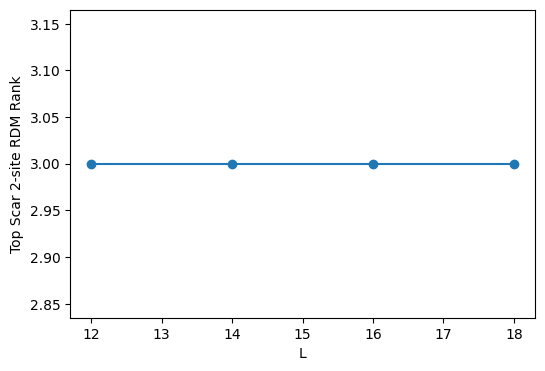

In [ ]:
# 2 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_2_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 2-site RDM Rank')
#plt.title('Domain Wall S=1/2 2-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('hb_scar_2p.png', dpi=300, bbox_inches='tight')
plt.show()

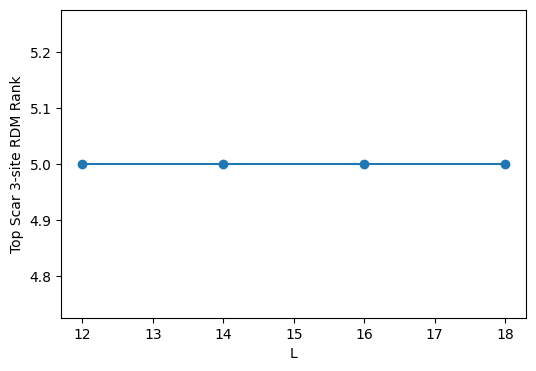

In [ ]:
# 3 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, hb_scar_3_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 3-site RDM Rank')
#plt.title('Domain Wall S=1/2 3-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('hb_scar_3p.png', dpi=300, bbox_inches='tight')
plt.show()

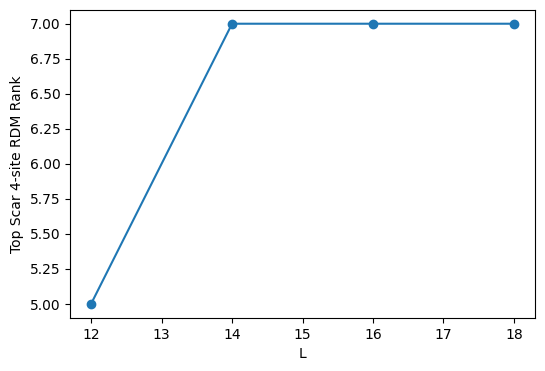

In [ ]:
# 4 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, dw_scar_4_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 4-site RDM Rank')
#plt.title('Domain Wall S=1/2 4-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('hb_scar_4p.png', dpi=300, bbox_inches='tight')
plt.show()